# Mobile inverted pendulum python dynamics
author:SeongHyeon Kim

program:PYDY balancing robot simulator


필요한 라이브러리 포함


In [1]:
from sympy import sin, cos, symbols, solve, Matrix, init_printing
from sympy.physics.mechanics import *
from sympy.physics.vector import ReferenceFrame
import sympy.physics.mechanics as me
import sympy as sm
import math as m
import numpy as np

In [2]:
init_vprinting()

# Reference frames

N은 외부의 기준 프레임. 속도를 0으로

In [3]:
#Newtonian reference frame
N=ReferenceFrame('N')

# Define a world coordinate origin
No = Point('No')
No.set_vel(N, 0)

In [4]:
F = ReferenceFrame('F')

P = ReferenceFrame('P')

F = N.orientnew('F', 'Axis',[psi, N.z] )     # Intermediate reference frame

P = F.orientnew('P', 'Axis', [theta, F.y])   # Inverted Pendulum

기준프레임.dcm(상대프레임)

## Newtonian, Bodies, Frames, Particles, Points


In [5]:
Mp =sm.symbols('Mp')
M = sm.symbols('M')

body_p_cm = me.Point('p_cm')
body_p_f = me.ReferenceFrame('p_f')
body_p = me.RigidBody('p', body_p_cm, body_p_f, Mp, (me.outer(body_p_f.x,body_p_f.x),body_p_cm))
body_l_cm = me.Point('l_cm')
body_l_f = me.ReferenceFrame('l_f')
body_l = me.RigidBody('l', body_l_cm, body_l_f, M, (me.outer(body_l_f.x,body_l_f.x),body_l_cm))
body_r_cm = me.Point('r_cm')
body_r_f = me.ReferenceFrame('r_f')
body_r = me.RigidBody('r', body_r_cm, body_r_f, M, (me.outer(body_r_f.x,body_r_f.x),body_r_cm))
frame_f = me.ReferenceFrame('f')
I = me.Point('i')
LN = me.Point('ln')
RN = me.Point('rn')

## Variables, Constants and Specified

In [6]:
x = me.dynamicsymbols('x')            # F1> measure number of Velocity of P in N
xd = me.dynamicsymbols('xd')
xd2 = me.dynamicsymbols('xdd')
theta = me.dynamicsymbols('theta')    # F2> measure number of Angular velocity of P in N
thetad = me.dynamicsymbols('thetad')
thetad2 = me.dynamicsymbols('thetadd')
delta = me.dynamicsymbols('delta')    # N3> measure number of Angular velocity of P in N
deltad = me.dynamicsymbols('deltad')
deltad2 = me.dynamicsymbols('deltadd')
wL = me.dynamicsymbols('wL')          # Angular velocity of L in N
wLd = me.dynamicsymbols('wL', 1)
wLd2 = me.dynamicsymbols('wL', 2)
wR = me.dynamicsymbols('wR')          # Angular velocity of R in N
wRd = me.dynamicsymbols('wR', 1)
wRd2 = me.dynamicsymbols('wR', 2)
TL, TR = me.dynamicsymbols('tL tR')   #Torques on L, R
g = sm.symbols('g', real=True)        #Gravitational acceleration
d = sm.symbols('d', real=True)        # Distance from point I to Lo (or Ro)
R = sm.symbols('r', real=True)        #Radius of wheels
l = sm.symbols('l', real=True)        # Distance from point I to mass center of P
t = sm.symbols('t')

## Mass and Inertia

###  Geometry relating unit vectors

In [7]:
F.orient(N, 'Axis', [delta, N.z])

In [8]:
P.orient(F, 'Axis', [theta, F.y])

In [9]:
N.dcm(F)

⎡cos(δ)  -sin(δ)  0⎤
⎢                  ⎥
⎢sin(δ)  cos(δ)   0⎥
⎢                  ⎥
⎣  0        0     1⎦

In [10]:
F.dcm(P)

⎡cos(θ)   0  sin(θ)⎤
⎢                  ⎥
⎢   0     1    0   ⎥
⎢                  ⎥
⎣-sin(θ)  0  cos(θ)⎦

## Position vectors

P_No_I = x*F.x    # Point No to I
P_I_Po = l*P.z    # Point I to mass center of P
P_I_Lo = d*F.y    # Point I to center of wheel L
P_I_Ro = -d*F.y   # Point I to center of wheel R
P_Lo_LN = -R*F.z   # Center of wheel L to contact point LN
P_Ro_RN = -R*F.z   # Center of wheel R to contact point RN

In [53]:
I = No.locatenew('I', x*F.x)      # Point No to I

Po = I.locatenew('Po', l*P.z)     # Point I to mass center of P

Lo = I.locatenew('Lo', d*F.y)     # Point I to center of wheel L

Ro = I.locatenew('Ro', -d*F.y)    # Point I to center of wheel R

LN = Lo.locatenew('LN', -R*F.z)   # Center of wheel L to contact point LN

RN = Ro.locatenew('RN', -R*F.z)   # Center of wheel R to contact point RN

## Angular Velocities


In [12]:
F.set_ang_vel(N, deltad*N.z)        # Angular velocity of F in N
P.set_ang_vel(F, thetad*F.y)        # Angular velocity of P in F
body_l_f.set_ang_vel(F, wLd*F.y)    # wL is related to w and v due to rolling
body_r_f.set_ang_vel(F, wRd*F.y)    # wR is related to w and v due to rolling

## Velocities of relevant points

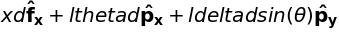

In [52]:
V_I_N = I.set_vel(N, xd*F.x)             # Velocity of point I in N

V_PO_N = Po.v2pt_theory(I,N,P)           # Velocity of center of mass of P

V_LO_N = Lo.v2pt_theory(I, N,P,)         # Velocity of center of L

V_RO_N = Ro.v2pt_theory(I,N,P)           # Velocity of center of R

V_LN_N = LN.v2pt_theory(Lo,N,body_l_f)          # Velocity of contact point of L

V_RN_N = RN.v2pt_theory(Ro,N,body_r_f)          # Velocity of contact point of R

V_PO_N


## Motion Constraints (relates wL and wR to w and v)


In [14]:
 D1 = dot(V_LN_N, F.x)     #Rolling without slipping condition of L
    
# Dependent[1] = x' - d*delta' - R*wL'
 D2 = dot(V_RN_N, F.x)    #Rolling without slipping condition of R

 #Dependent[2] = x' + d*delta' - R*wR'
 [D1,D2]
 

In [15]:
#Constrain(Dependent[wLd,wRd])     ???
wLd = (xd-d*deltad)/R
wRd = (xd+d*deltad)/R
wLd2 = (xd2-d*deltad2)/R
wRd2 = (xd2+d*deltad2)/R


### Forces

In [41]:
#중력벡터
Gravity = -g * N.z
fL = []

fL.extend([(body_p_f, -g*Mp*N.z),(body_r_f, -g*M*N.z),(body_l_f, -g*M*N.z)],)

In [42]:

fL.append( (body_l_f, TL*F.y))     #Torques on L

    
fL.append((body_r_f, TR*F.y))    #Torques on R

fL

[(p_f, - Mp*g*N.z),
 (r_f, - M*g*N.z),
 (l_f, - M*g*N.z),
 (l_f, tL*F.y),
 (r_f, tR*F.y)]

## Kane's equations of motion


In [43]:
from sympy import trigsimp
from sympy.physics.mechanics import KanesMethod

In [44]:
q = [x, theta, delta]
q

In [45]:
qd = [xd, thetad, deltad]
qd

In [46]:
kd = [xd - x.diff(),
        thetad - theta.diff(),
         deltad -delta.diff()]

In [47]:
KM = KanesMethod(N, q, qd, kd)

In [48]:
bodies = [body_p, body_r, body_l]
bodies

[p, r, l]

In [49]:
fL

[(p_f, - Mp*g*N.z),
 (r_f, - M*g*N.z),
 (l_f, - M*g*N.z),
 (l_f, tL*F.y),
 (r_f, tR*F.y)]

In [50]:
fr, frstar = KM.kanes_equations(bodies, fL)

ValueError: No Connecting Path found between p_f and N